In [5]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd
from pandas import Timestamp
from wrf import to_np, getvar, smooth2d, get_basemap, latlon_coords, extract_times, ALL_TIMES, interplevel
import sys, os, glob
import xarray as xr
import atmos

mpl.font_manager._rebuild()

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.style'] = 'normal'

def landmarks():
    landmark_dict = {'C':(-64.2123,-31.3154),
                    'M':(-68.7987,-32.8278),
                    '3':(-64.1131,-32.1767),
                    '4':(-64.34992,-33.13067), 
                    'Y':(-64.7545,-32.1062),
                    'S':(-63.978435,-31.715689),
                    'SR':(-68.285522,-34.587997),
                    'SL':(-66.33694,-33.30278)}
    return landmark_dict

landmark_dict=landmarks()

#run='2015-11-07_00:00:00'
#tindex=np.all([])
#tindex=np.arange(0,24,1) 

run='2017-11-25_00:00:00'
tindex=int(3)
zoom='cba'


############################tCONFIGURATION PARAMETERS###############################
titlestr='Servicio Meteorologico Nacional GFS-WRF '
model='SMN_WRF'
filenames=sorted(glob.glob('/data/snesbitt/f/snesbitt/domains/smn/wrfprs_20171125_00.0??'))
outpath='/data/meso/a/snesbitt/wrf3911/fcsts/'+model+'/'+run+'/images'
############################tCONFIGURATION PARAMETERS###############################

if (zoom == 'full') or (zoom == ''):
    skip=17
    fontsize=12
    mapscale=3000
    modname=model+'_full'
    mapparms=[-32.8,-32.8,-32.8,-67.0]
elif zoom == 'cba':
    skip=10
    fontsize=14
    mapscale=1500
    modname=model+'_cba'
    mapparms=[-32.2,-32.2,-32.2,-65.0]
elif zoom == 'mdz':
    skip=10
    fontsize=14
    mapscale=1500
    modname=model+'_mdz'
    mapparms=[-33.2,-33.2,-33.2,-69.0]

#print(filenames)
print(run,tindex)

os.system('mkdir -p '+outpath)

basetime=pd.to_datetime(run, format='%Y-%m-%d_%H:%M:%S')

files=[]
times=[]
#times=pd.date_range(start=basetime,periods=43,freq='H')


if model == 'SMN_WRF':
    print('doing SMN_WRF')
    data=xr.open_dataset(filenames[tindex],engine='pynio')
    terr=xr.open_dataset('SMN_HGT.nc')
    topo=np.squeeze(terr['HGT'].values)
else:
    for file in filenames:
            files.append(Dataset(file))
            print(os.path.basename(file)[11:])
            times.append(pd.to_datetime(os.path.basename(file)[11:],format='%Y-%m-%d_%H:%M:%S'))
    topo=getvar(files, 'ter', timeidx=0, units='m')


def make_plot(cffield,lfield,lfield2,ufld,vfld,params):

    print(params['time_index'])
    ,'lons':,'lats':data['g3_lat_0'].values}
    if type(cffield) == type(xr.DataArray(None)):
        lats = data['g3_lat_0'].values
        lons = data['g3_lon_1'].values
    else:
        lats, lons = latlon_coords(cffield)

    # Get the basemap object

    bm = Basemap(projection='lcc',width=params['mapscale']*550,height=params['mapscale']*375,
             resolution='i',lat_1=params['mapparms'][0],
             lat_2=params['mapparms'][1],
             lat_0=params['mapparms'][2],
             lon_0=params['mapparms'][3])
    
    # Create a figure
    fig = plt.figure(figsize=(12,9))

    # Add geographic outlines
    bm.drawcoastlines(linewidth=0.75)
    bm.drawstates(linewidth=1.)
    bm.drawcountries(linewidth=1.)

    # Convert the lats and lons to x and y.  Make sure you convert the lats and lons to
    # numpy arrays via to_np, or basemap crashes with an undefined RuntimeError.
    if type(cffield) == type(xr.DataArray(None)):
        x,y = bm(lons, lats)
    else:
        x, y = bm(to_np(lons), to_np(lats))


    if lfield is not None:
        if type(cffield) == type(xr.DataArray(None)):
            CS=bm.contour(x, y, lfield.values, 10, colors="black", levels=params['llevels'],linewidths=1.0)
        else:
            CS=bm.contour(x, y, to_np(lfield), 10, colors="black", levels=params['llevels'],linewidths=1.0)
        plt.clabel(CS, inline=1, fontsize=12, fmt='%d')

    if lfield2 is not None:
        if type(cffield) == type(xr.DataArray(None)):
            CS=bm.contour(x, y, lfield2, 10, colors="dimgrey", levels=params['llevels2'],linewidths=2.25)
        else:
            CS=bm.contour(x, y, to_np(lfield2), 10, colors="dimgrey", levels=params['llevels2'],linewidths=2.25)
        #plt.clabel(CS, inline=1, fontsize=12, fmt='%d')
    
    if ufld is not None:
        if type(cffield) == type(xr.DataArray(None)):
            bm.barbs(x[::params['skip'],::params['skip']], 
                     y[::params['skip'],::params['skip']], 
                     ufld[::params['skip'],::params['skip']].values,
                     vfld[::params['skip'],::params['skip']].values, length=5, linewidth=0.75, zorder=10)

        else:
            bm.barbs(x[::params['skip'],::params['skip']], 
                     y[::params['skip'],::params['skip']], 
                     to_np(ufld[::params['skip'],::params['skip']]),
                     to_np(vfld[::params['skip'],::params['skip']]), length=5, linewidth=0.75, zorder=10)

    if not('lalpha' in params):
        params['lalpha']=None
        

    # Draw the contours and filled contours
    if type(cffield) == type(xr.DataArray(None)):
        bm.contourf(x, y, cffield.values, 10, cmap=get_cmap(params['ccmap']), levels=params['clevels'], extend='both',
               alpha=params['lalpha'])
    else:
        bm.contourf(x, y, to_np(cffield), 10, cmap=get_cmap(params['ccmap']), levels=params['clevels'], extend='both',
               alpha=params['lalpha'])


    parallels = np.arange(-50.,-10.,2.)
    # labels = [left,right,top,bottom]
    bm.drawparallels(parallels,labels=[False,True,False,False],linewidth=0.5,dashes=[2,2])
    meridians = np.arange(-90.,-50.,2.)
    bm.drawmeridians(meridians,labels=[False,False,False,True],linewidth=0.5,dashes=[2,2])

    # Add a color bar
    plt.colorbar(shrink=.62, extend='both')

    if type(cffield) == type(xr.DataArray(None)):
        initial_time=pd.to_datetime(cffield.initial_time,format='%m/%d/%Y (%H:%M)')
        valid_time=initial_time+pd.offsets.relativedelta(hours=float(cffield.forecast_time[0]))
        timediff_secs=data['P_WAT_GDS3_EATM'].forecast_time[0]
        initial_time=initial_time.strftime('%Y-%m-%d_%H:%M')
        plt.title(titlestr+' '+cffield.long_name+' ('+cffield.units+')\n'+
                 "Initialized: "+initial_time+"Z Forecast hour: "+'{:03d}'.format(timediff_secs)+" Valid: "+valid_time.strftime('%Y-%m-%d %H:%M')+'Z')
    
    else:
        timediff=params['times'][params['time_index']]-params['times'][0]
        timediff_secs=int(timediff.total_seconds()//3600)
        initial_time=params['times'][0].strftime('%Y-%m-%d_%H:%M')
        plt.title(titlestr+' '+cffield.description+' ('+cffield.units+')\n'+
                 "Initialized: "+initial_time+"Z Forecast hour: "+'{:03d}'.format(timediff_secs)+" Valid: "+params['times'][params['time_index']].strftime('%Y-%m-%d %H:%M')+'Z')


    for key in landmark_dict.keys():
        kx,ky=bm(landmark_dict[key][0],landmark_dict[key][1])
        plt.text(kx,ky,key,fontsize=params['fontsize'],
                        ha='center',va='center',color='b')
    #fig.figimage(im, fig.bbox.xmax-290, fig.bbox.ymin,zorder=10)


#----
#    def draw_screen_poly( lats, lons, bm):
#             x, y = bm( lons, lats )
#             xy = zip(x,y)
#             poly = Polygon( xy, facecolor='black', alpha=0.45 )
#             plt.gca().add_patch(poly)
#            
#    lats = [ -33, -30, -30, -33 ]
#    lons = [ -65, -65, -62, -62 ]
#    draw_screen_poly( lats, lons, bm )

#----

#Drawing a 200-km range ring around S-PolKa site----
    def shoot(lon, lat, azimuth, maxdist=None):
        """Shooter Function
        Original javascript on http://williams.best.vwh.net/gccalc.htm
        Translated to python by Thomas Lecocq
        """
        glat1 = lat * np.pi / 180.
        glon1 = lon * np.pi / 180.
        s = maxdist / 1.852
        faz = azimuth * np.pi / 180.
 
        EPS= 0.00000000005
        if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
            alert("Only N-S courses are meaningful, starting at a pole!")
 
        a=6378.13/1.852
        f=1/298.257223563
        r = 1 - f
        tu = r * np.tan(glat1)
        sf = np.sin(faz)
        cf = np.cos(faz)
        if (cf==0):
            b=0.
        else:
            b=2. * np.arctan2 (tu, cf)
 
        cu = 1. / np.sqrt(1 + tu * tu)
        su = tu * cu
        sa = cu * sf
        c2a = 1 - sa * sa
        x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
        x = (x - 2.) / x
        c = 1. - x
        c = (x * x / 4. + 1.) / c
        d = (0.375 * x * x - 1.) * x
        tu = s / (r * a * c)
        y = tu
        c = y + 1
        while (np.abs (y - c) > EPS):
 
            sy = np.sin(y)
            cy = np.cos(y)
            cz = np.cos(b + y)
            e = 2. * cz * cz - 1.
            c = y
            x = e * cy
            y = e + e - 1.
            y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
                  d / 4. - cz) * sy * d + tu
 
        b = cu * cy * cf - su * sy
        c = r * np.sqrt(sa * sa + b * b)
        d = su * cy + cu * sy * cf
        glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
        c = cu * cy - su * sy * cf
        x = np.arctan2(sy * sf, c)
        c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
        d = ((e * cy * c + cz) * sy * c + y) * sa
        glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi    
 
        baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)
 
        glon2 *= 180./np.pi
        glat2 *= 180./np.pi
        baz *= 180./np.pi
 
        return (glon2, glat2, baz)


    def equi(bm, centerlon, centerlat, radius, *args, **kwargs):
        glon1 = centerlon
        glat1 = centerlat
        X = []
        Y = []
        for azimuth in range(0, 360):
            glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
            X.append(glon2)
            Y.append(glat2)
        X.append(X[0])
        Y.append(Y[0])
 
        #m.plot(X,Y,**kwargs) #Should work, but doesn't...
        X,Y = bm(X,Y)
        plt.plot(X,Y,**kwargs)

    radii = [200]
 
    # S-PolKa:
    centerlon = -63.978435
    centerlat = -31.715689
    for radius in radii:
        equi(bm, centerlon, centerlat, radius,lw=1.5,color='k')

    # San Rafael:
    centerlon = -68.285522
    centerlat = -34.587997
    for radius in radii:
        equi(bm, centerlon, centerlat, radius,lw=1.5,color='k')

    # Mendoza:
    centerlon = -68.7987
    centerlat = -32.8278
    for radius in radii:
        equi(bm, centerlon, centerlat, radius,lw=1.5,color='k')

#----

    os.system('mkdir -p '+outpath+'/'+params['modfld'])
    print("Creating: "+outpath+'/'+params['modfld']+'/model.'+params['modname']+'.'+initial_time+'.'+'{:03d}'.format(timediff_secs)+'_'+params['modfld']+'.png')

    plt.savefig(outpath+'/'+params['modfld']+'/model.'+params['modname']+'.'+initial_time+'.'+'{:03d}'.format(timediff_secs)+'_'+params['modfld']+'.png',dpi=225,bbox_inches='tight')

    plt.close()
# In[512]:

#====================MAX SFC WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'max_sfc_wind',
        'cfield':'WSPD10MAX',
        'clevels':np.arange(0,100,2),
        'ccmap':"gist_stern_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


try:
	cffield = getvar(files, params['cfield'], timeidx=params['time_index'], units='kt')
	cffield.values=cffield.values*1.94384
	#cffield.attrs['description']='maximum surface wind'
	cffield.attrs['units']='kt'
	lfield = None
	lfield2 = topo
	ufld = None
	vfld = None

	make_plot(cffield,lfield,ufld,vfld,params)
except: print(params['cfield']," is not in the file, skipping")


# In[504]:
#=========================MIN UH=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'upheli',
        'cfield':'UP_HELI_MIN',
        'clevels':np.arange(0,220,20),
        'ccmap':"gist_stern_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


try:
	cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
	cffield.values=cffield.values*-1.
	cffield.attrs['description']='updraft helicity'
	cffield.attrs['units']='m2 s-2'
	lfield = None
	lfield2 = topo
	ufld = None
	vfld = None

	make_plot(cffield,lfield,lfield2,ufld,vfld,params)
except: print(params['cfield']," is not in the file, skipping")

# In[496]:

#=========================0-1 km SRH=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'0_1km_srh',
        'cfield':'SRH_MIN1',
        'clevels':np.arange(0,750,25),
        'ccmap':"cubehelix_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


try:
	cffield = getvar(files, 'helicity', timeidx=params['time_index'],top=1000.0)
	cffield.values=cffield.values*-1.
	cffield.attrs['description']='0-1 km AGL storm relative helicity'
	cffield.attrs['units']='m2 s-2'
	lfield = None
	lfield2 = topo
	uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
	ufld = uvmet.isel(u_v=0)
	vfld = uvmet.isel(u_v=1)

	make_plot(cffield,lfield,lfield2,ufld,vfld,params)
except: print(params['cfield']," is not in the file, skipping")

#====================TOTAL PRECIPITAITON=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'precip_acc',
        'cfield':'RAINNC',
        'clevels':np.arange(0,165,10),
        'ccmap':"ocean_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

try:
	cffield=None
	cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
	cffield.attrs['description']='total precipitation'
	cffield.attrs['units']='mm'
	lfield = None
	lfield2 = topo
	ufld = None
	vfld = None

	make_plot(cffield,lfield,lfield2,ufld,vfld,params)

except:
	except: print(params['cfield']," is not in the file, skipping")	

# In[495]:

#====================MAX UPDRAFT=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'max_w',
        'cfield':'W_UP_MAX',
        'clevels':np.arange(0,100,2),
        'ccmap':"gist_stern_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


try:
	cffield = getvar(files, params['cfield'], timeidx=params['time_index'], units='kt')
	cffield.values=cffield.values*1.94384
	cffield.attrs['description']='maximum updraft velocity'
	cffield.attrs['units']='kt'
	lfield = None
	lfield2 = topo
	ufld = None
	vfld = None

	make_plot(cffield,lfield,lfield2,ufld,vfld,params)
except: print(params['cfield']," is not in the file, skipping")


#=====================PRECIPITABLE WATER=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'pwat',
        'cfield':'pw',
        'clevels':np.arange(15,75,5),
        'ccmap':"viridis_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    cffield = data['P_WAT_GDS3_EATM']
    lfield = None
    lfield2 = topo
    ufld = None
    vfld = None
else:
    cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
    lfield = None
    lfield2 = topo
    ufld = None
    vfld = None

make_plot(cffield,lfield,lfield2,ufld,vfld,params)

#=========================0-3 km SRH=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'0_3km_srh',
        'cfield':'SRH_MIN3',
        'clevels':np.arange(0,950,25),
        'ccmap':"cubehelix_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


try:
    if model == 'SMN_WRF':
        cffield = data['HLCY_GDS3_HTGY']
        cffield.values = cffield.values*-1.
        lfield = None
        lfield2 = topo
        ufld = data['U_GRD_GDS3_HTGL']*1.94
        vfld = data['V_GRD_GDS3_HTGL']*1.94

    else:
        cffield = getvar(files, 'helicity', timeidx=params['time_index'],top=3000.0)
        cffield.values=cffield.values*-1.
        cffield.attrs['description']='0-3 km AGL storm relative helicity'
        cffield.attrs['units']='m2 s-2'
        lfield = None
        lfield2 = topo
        uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
        ufld = uvmet.isel(u_v=0)
        vfld = uvmet.isel(u_v=1)

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
except: 
    print(params['cfield']," is not in the file, skipping")

#====================1 HOUR PRECIPITAITON=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'precip_1hr',
        'cfield':'PREC_ACC_NC',
        'clevels':np.arange(0,42,2),
        'ccmap':"ocean_r",
        'llevels':None,
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

try:
    if model == 'SMN_WRF':
        cffield = data['A_PCP_GDS3_SFC_acc1h']
        lfield = None
        lfield2 = topo
        ufld = None
        vfld = None
    else:

        cffield=None
        cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
        cffield.attrs['description']='hourly precipitation'
        cffield.attrs['units']='mm'
        lfield = None
        lfield2 = topo
        ufld = None
        vfld = None 
    make_plot(cffield,lfield,lfield2,ufld,vfld,params)
    
except: 
    print(params['cfield']," is not in the file, skipping")

#=====================2 M TEMP=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'T2',
        'cfield':'T2',
        'clevels':np.arange(-15,40,2.5),
        'ccmap':"plasma",
        'llevels':np.arange(970,1040,4),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


if model == 'SMN_WRF':
    cffield = data['TMP_GDS3_HTGL']
    cffield.values = cffield.values-273.15
    lfield = data['PRMSL_GDS3_MSL']/100.
    lfield2 = topo
    ufld = data['U_GRD_GDS3_HTGL']*1.94
    vfld = data['V_GRD_GDS3_HTGL']*1.94
else:
    cffield = getvar(files, params['cfield'], timeidx=params['time_index'],units='degC')
    cffield.attrs['description']='2 m temperature'
    cffield.attrs['temperature']='degC'
    cffield.values=cffield.values-273.15
    lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield2 = topo
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,lfield2,ufld,vfld,params)

    
    
#=====================2 M DWPT=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'TD2',
        'cfield':'td2',
        'clevels':np.arange(-5,30,2.5),
        'ccmap':"YlGn",
        'llevels':np.arange(970,1040,4),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

#try:
if model == 'SMN_WRF':
    cffield = data['DPT_GDS3_HTGL']
    cffield.values = cffield.values-273.15
    lfield = data['PRMSL_GDS3_MSL']/100.
    lfield2 = topo
    ufld = data['U_GRD_GDS3_HTGL']*1.94
    vfld = data['V_GRD_GDS3_HTGL']*1.94
else:
    cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
    cffield.attrs['description']='2 m dewpoint temperature'
    cffield.attrs['temperature']='degC'
    cffield.values=cffield.values
    lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield2 = topo
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,lfield2,ufld,vfld,params)
#except: 
#    print(params['cfield']," is not in the file, skipping")
#=====================SFC THETAE=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'theta_e_sfc',
        'cfield':'eth',
        'clevels':np.arange(290,390,10),
        'ccmap':"viridis_r",
        'llevels':np.arange(970,1040,4),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    cffield = data['TMP_GDS3_HTGL']
    cffield.values = 273.15+atmos.calculate('thetae', T=data['TMP_GDS3_HTGL'].values, p=data['PRES_GDS3_SFC'].values, qv=data['SPF_H_GDS3_HTGL'].values)
    cffield.attrs['long_name']='2 m equivalent potential temperature'
    cffield.attrs['units']='K'
    lfield = data['PRMSL_GDS3_MSL']/100.
    lfield2 = topo
    ufld = data['U_GRD_GDS3_HTGL']*1.94
    vfld = data['V_GRD_GDS3_HTGL']*1.94
else:
    cffield = getvar(files, params['cfield'], timeidx=params['time_index'], units='K')
    cffield=cffield.isel(bottom_top=0)
    lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield2 = topo
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,lfield2,ufld,vfld,params)

#=====================10 M WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'WSP',
        'cfield':'wsp',
        'clevels':np.arange(8,40,4),
        'ccmap':"YlOrBr",
        'llevels':np.arange(970,1040,4),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    cffield = data['U_GRD_GDS3_HTGL']
    cffield.values=1.94*np.sqrt(data['U_GRD_GDS3_HTGL']**2.0+data['V_GRD_GDS3_HTGL']**2.0)
    cffield.attrs['long_name']='10 m wind'
    cffield.attrs['units']='kt'
    lfield = data['PRMSL_GDS3_MSL']/100.
    lfield2 = topo
    ufld = data['U_GRD_GDS3_HTGL']*1.94
    vfld = data['V_GRD_GDS3_HTGL']*1.94
else:
    uvmet10 = getvar(files, 'wspd_wdir10', timeidx=params['time_index'], units="kt")

    cffield = uvmet10.isel(wspd_wdir=0)
    cffield.attrs['description']='10 m wind'
    lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
    lfield2 = topo
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,lfield2,ufld,vfld,params)

#=====================0-1 KM WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'lcl_0-1kmwind',
        'cfield':'lcl_0-1kmwind',
        'clevels':np.arange(500,4000,250),
        'ccmap':"ocean",
        'llevels':np.arange(10,50,5),
        'llevels2':[1000],
        'lalpha':0.7,
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


if model == 'SMN_WRF':
    print('not implemented yet')
else:
    uvmet10 = getvar(files, 'wspd_wdir10', timeidx=params['time_index'], units="kt")

    ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
    z = getvar(files, 'z', timeidx=params['time_index'], units="m")
    p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
    u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
    v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

    ter_3d=np.tile(ter.values,[41,1,1])
    z.values=z.values-ter.values
    u2 = interplevel(u, z, 1000)
    v2 = interplevel(v, z, 1000)
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

    u2.values=u2.values-ufld.values
    v2.values=v2.values-vfld.values

    lfield = uvmet10.isel(wspd_wdir=0)
    lfield.values=smooth2d(np.sqrt(u2.values**2.+v2.values**2.),3)

    lfield2 = topo

    sounding_parameters=getvar(files, 'cape_2d', timeidx=params['time_index'])
    cffield = sounding_parameters.isel(mcape_mcin_lcl_lfc=3)

    cffield.attrs['description']='lcl, 0-1 km bulk wind difference'
    cffield.attrs['units']='m; kt'
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = u2
    vfld = v2

 
    make_plot(cffield,lfield,lfield2,ufld,vfld,params)


#=====================MLCAPE; 0-6 KM WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'mlcape_0-6kmwind',
        'cfield':'mlcape_0-6kmwind',
        'clevels':np.arange(0,4000,200),
        'ccmap':"viridis_r",
        'llevels':np.arange(10,50,5),
        'llevels2':[1000],
        'lalpha':0.7,
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}


if model == 'SMN_WRF':
    cffield = data['CAPE_GDS3_SFC']
    cffield.values = np.ma.masked_less(cffield.values,5.)
    lfield = None
    lfield2 = topo
    ufld = None
    vfld = None
else:

    uvmet10 = getvar(files, 'wspd_wdir10', timeidx=params['time_index'], units="kt")

    ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
    z = getvar(files, 'z', timeidx=params['time_index'], units="m")
    p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
    u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
    v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

    ter_3d=np.tile(ter.values,[41,1,1])
    z.values=z.values-ter.values
    u2 = interplevel(u, z, 6000)
    v2 = interplevel(v, z, 6000)
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = uvmet.isel(u_v=0)
    vfld = uvmet.isel(u_v=1)

    u2.values=u2.values-ufld.values
    v2.values=v2.values-vfld.values

    lfield = uvmet10.isel(wspd_wdir=0)
    lfield.values=smooth2d(np.sqrt(u2.values**2.+v2.values**2.),3)

    lfield2 = topo

    sounding_parameters=getvar(files, 'cape_2d', timeidx=params['time_index'])
    cffield = sounding_parameters.isel(mcape_mcin_lcl_lfc=0)

    cffield.attrs['description']='MLCAPE, 0-6 km bulk wind difference'
    cffield.attrs['units']='J kg-1; kt'
    uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
    ufld = u2
    vfld = v2

make_plot(cffield,lfield,lfield2,ufld,vfld,params)

#=========================500 M=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'wsp_500m',
        'cfield':'wsp_500m',
        'clevels':np.arange(8,40,4),
        'ccmap':"YlOrBr",
        'llevels':np.arange(510,606,6),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    print('not implemented yet')
else:
    uvmet = getvar(files, 'wspd_wdir', timeidx=params['time_index'], units="kt")
    wspd = uvmet.isel(wspd_wdir=0)
    ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
    z = getvar(files, 'z', timeidx=params['time_index'], units="m")
    p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
    u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
    v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

    ter_3d=np.tile(ter.values,[41,1,1])
    z.values=z.values-ter.values
    cffield = interplevel(wspd, z, 500)
    cffield.attrs['description']='500 m AGL winds'
    lfield = None
    lfield2 = topo
    ufld = interplevel(u, z, 500)
    vfld = interplevel(v, z, 500)

    make_plot(cffield,lfield,lfield2,ufld,vfld,params)

#=========================1 km DBZ=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'radar_1km',
        'cfield':'radar_1km',
        'clevels':np.arange(5,75,5.),
        'ccmap':"gist_ncar",
        'llevels':np.arange(510,606,6),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    cffield = data['REFD_GDS3_HTGL']
    cffield.values=np.ma.masked_less(cffield.values,-10.)
    lfield = None
    lfield2 = topo
    ufld = None
    vfld = None
else:

    dbz = getvar(files, 'dbz', timeidx=params['time_index'])
    ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
    z = getvar(files, 'z', timeidx=params['time_index'], units="m")

    ter_3d=np.tile(ter.values,[41,1,1])
    z.values=z.values-ter.values
    cffield = interplevel(dbz, z, 1000)
    cffield.values=np.ma.masked_less(cffield.values,-10.)
    cffield.attrs['description']='1 km AGL radar reflectivity'
    lfield = None
    lfield2 = topo
    ufld=None
    vfld=None

make_plot(cffield,lfield,lfield2,ufld,vfld,params)

#=========================500 HPA=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'500avo',
        'cfield':'avo',
        'clevels':[-12,-9,-6,-3,0,12,15,18,21,24],
        'ccmap':"RdBu",
        'lalpha':0.7,
        'llevels':np.arange(510,606,6),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    cffield = data['ABS_V_GDS3_ISBL']
    cffield.values=cffield.values*-1e4
    lfield = data['HGT_GDS3_ISBL'].sel(lv_ISBL2=500)
    lfield2 = topo
    ufld = data['U_GRD_GDS3_ISBL'].sel(lv_ISBL2=500)*1.94
    vfld = data['V_GRD_GDS3_ISBL'].sel(lv_ISBL2=500)*1.94
else:

    avo = getvar(files, 'avo', timeidx=params['time_index'])
    z = getvar(files, 'z', timeidx=params['time_index'], units="dm")
    p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
    u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
    v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

    cffield = interplevel(avo, p, 500)
    cffield.values=cffield.values*-1
    cffield.attrs['description']='500 hPa absolute vorticity'
    lfield = interplevel(z, p, 500)
    lfield2 = topo
    ufld = interplevel(u, p, 500)
    vfld = interplevel(v, p, 500)

make_plot(cffield,lfield,lfield2,ufld,vfld,params)


# In[510]:


#=========================200 HPA=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'200_V',
        'cfield':'200_V',
        'clevels':np.arange(40,160,20),
        'ccmap':"plasma_r",
        'lalpha':0.7,
        'llevels':np.arange(1100,1300,12),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    
    cffield = data['U_GRD_GDS3_HTGL']
    cffield.values=1.94*np.sqrt(data['U_GRD_GDS3_ISBL'].sel(lv_ISBL2=200)**2.0+data['V_GRD_GDS3_ISBL'].sel(lv_ISBL2=200)**2.0)
    cffield.attrs['long_name']='200 hPa isotachs'
    cffield.attrs['units']='kt'
    lfield = data['HGT_GDS3_ISBL'].sel(lv_ISBL2=200)/100.
    lfield2 = topo
    ufld = data['U_GRD_GDS3_ISBL'].sel(lv_ISBL2=200)*1.94
    vfld = data['V_GRD_GDS3_ISBL'].sel(lv_ISBL2=200)*1.94

else:
    uvmet = getvar(files, 'wspd_wdir', timeidx=params['time_index'], units="kt")
    wspd = uvmet.isel(wspd_wdir=0)
    z = getvar(files, 'z', timeidx=params['time_index'], units="dm")
    p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
    u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
    v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

    cffield = interplevel(wspd, p, 200)
    cffield.values=cffield.values
    cffield.attrs['description']='200 hPa isotachs'
    cffield.values=np.ma.masked_less(cffield.values,40.)
    lfield = interplevel(z, p, 200)
    lfield2 = topo
    ufld = interplevel(u, p, 200)
    vfld = interplevel(v, p, 200)

make_plot(cffield,lfield,lfield2,ufld,vfld,params)


# In[546]:


#=========================850 HPA=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'850_theta',
        'cfield':'850_theta',
        'clevels':np.arange(-300,340,40),
        'ccmap':"BrBG",
        'lalpha':0.7,
        'llevels':np.arange(250,400,5),
        'llevels2':[1000],
        'time_index':tindex,
        'times':times,
        'skip':skip,
        'mapscale':mapscale,
        'mapparms':mapparms,
        'fontsize':fontsize}

if model == 'SMN_WRF':
    lfield = data['TMP_GDS3_HTGL']
    lfield.values = 273.15+atmos.calculate('thetae', T=data['TMP_GDS3_ISBL'].sel(lv_ISBL2=850).values, p=85000.+np.zeros(np.shape(data['TMP_GDS3_HTGL'].values)), qv=data['SPF_H_GDS3_ISBL'].sel(lv_ISBL2=850).values)
    lfield.attrs['long_name']='850 hPa equivalent potential temperature'
    lfield.attrs['units']='K'
    ufld = data['U_GRD_GDS3_ISBL'].sel(lv_ISBL2=850)
    vfld = data['V_GRD_GDS3_ISBL'].sel(lv_ISBL2=850)
    qfld = data['SPF_H_GDS3_ISBL'].sel(lv_ISBL2=850)
    dx=data.g3_lat_0[1,0]-data.g3_lat_0[0,0]
    dx=dx.values*111100
    grad_q_x,grad_q_y = np.gradient(qfld.values)
    grad_u_x,grad_u_y = np.gradient(ufld.values)
    grad_v_x,grad_v_y = np.gradient(vfld.values)

    MFC_advect=-1.*(ufld.values*grad_q_x/dx)+(vfld.values*grad_q_y/dx)
    MFC_conv=-1.*qfld.values*((grad_u_x/dx)+(grad_v_y/dx))
    cffield = data['TMP_GDS3_HTGL']
    cffield.values=-1.*86400.*1000.*(MFC_advect + MFC_conv)
    cffield.attrs['description']='850 hPa moisture convergence and theta-e'
    cffield.attrs['units']='g kg-1 dy-1; K'

else:
    uvmet = getvar(files, 'wspd_wdir', timeidx=params['time_index'], units="kt")
    wspd = uvmet.isel(wspd_wdir=0)
    eth = getvar(files, 'eth', timeidx=params['time_index'])
    q = getvar(files, 'QVAPOR', timeidx=params['time_index'])

    dx=uvmet.XLAT[1,0]-uvmet.XLAT[0,0]
    dx=dx.values*111100
    #MFC_advect = -( u*(dq/dx)+v*(dq/dy) )    ; advection term
    #    MFC_conv    = -q*( (du/dx)+  (dv/dy) )      ; con(div)-vergence
    #    MFC = MFC_advect + MFC_conv

    p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
    u = getvar(files, 'ua', timeidx=params['time_index'])
    v = getvar(files, 'va', timeidx=params['time_index'])
    ufld = interplevel(u, p, 850)
    vfld = interplevel(v, p, 850)
    qfld = interplevel(q, p, 850)

    grad_q_x,grad_q_y = np.gradient(qfld.values)
    grad_u_x,grad_u_y = np.gradient(ufld.values)
    grad_v_x,grad_v_y = np.gradient(vfld.values)

    MFC_advect=-1.*(ufld.values*grad_q_x/dx)+(vfld.values*grad_q_y/dx)
    MFC_conv=-1.*qfld.values*((grad_u_x/dx)+(grad_v_y/dx))

    cffield = qfld
    cffield.values=-1.*smooth2d(86400.*1000.*(MFC_advect + MFC_conv),5)
    cffield.attrs['description']='850 hPa moisture convergence and theta-e'
    cffield.attrs['units']='g kg-1 dy-1; K'
    lfield = smooth2d(interplevel(eth, p, 850),3)
    lfield2 = topo
    ufld = ufld*1.94
    vfld = vfld*1.94

make_plot(cffield,lfield,lfield2,ufld,vfld,params)




2017-11-25_00:00:00 3
doing SMN_WRF
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/pwat/model.SMN_WRF_cba.2017-11-25_00:00.003_pwat.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/0_3km_srh/model.SMN_WRF_cba.2017-11-25_00:00.003_0_3km_srh.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/precip_1hr/model.SMN_WRF_cba.2017-11-25_00:00.003_precip_1hr.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/T2/model.SMN_WRF_cba.2017-11-25_00:00.003_T2.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/TD2/model.SMN_WRF_cba.2017-11-25_00:00.003_TD2.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/theta_e_sfc/model.SMN_WRF_cba.2017-11-25_00:00.003_theta_e_sfc.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/WSP/model.SMN_WRF_cba.2017-11-25_00

/data/keeling/a/snesbitt/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/500avo/model.SMN_WRF_cba.2017-11-25_00:00.003_500avo.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/200_V/model.SMN_WRF_cba.2017-11-25_00:00.003_200_V.png
3
Creating: /data/meso/a/snesbitt/wrf3911/fcsts/SMN_WRF/2017-11-25_00:00:00/images/850_theta/model.SMN_WRF_cba.2017-11-25_00:00.003_850_theta.png


In [13]:
data

<xarray.Dataset>
Dimensions:               (g3_x_0: 1249, g3_y_1: 999, lv_ISBL2: 25)
Coordinates:
  * lv_ISBL2              (lv_ISBL2) int32 50 100 150 200 250 300 350 400 ...
    g3_lat_0              (g3_x_0, g3_y_1) float32 -54.387 -54.3968 -54.4065 ...
    g3_lon_1              (g3_x_0, g3_y_1) float32 -94.331 -94.2755 -94.2201 ...
Dimensions without coordinates: g3_x_0, g3_y_1
Data variables:
    PRES_GDS3_SFC         (g3_x_0, g3_y_1) float64 ...
    PRMSL_GDS3_MSL        (g3_x_0, g3_y_1) float64 9.905e+04 9.905e+04 ...
    HGT_GDS3_0DEG         (g3_x_0, g3_y_1) float64 ...
    HGT_GDS3_ISBL         (lv_ISBL2, g3_x_0, g3_y_1) float64 ...
    TMP_GDS3_ISBL         (lv_ISBL2, g3_x_0, g3_y_1) float64 ...
    TMP_GDS3_HTGL         (g3_x_0, g3_y_1) float64 ...
    DPT_GDS3_ISBL         (g3_x_0, g3_y_1) float64 ...
    DPT_GDS3_HTGL         (g3_x_0, g3_y_1) float64 6.686 6.682 6.686 6.696 ...
    U_GRD_GDS3_ISBL       (lv_ISBL2, g3_x_0, g3_y_1) float64 ...
    U_GRD_GDS3_HTGL       (g3_

In [36]:
def vinterp(grid, surface, interplevels):
    shape = ( interplevels.shape[0], grid.shape[1], grid.shape[2] )
    outgrid = np.empty( shape )
    for idx, val in np.ndenumerate( grid[0] ):
        ## get the column slice of pressure
        column = surface[ ::-1, idx[0], idx[1] ]
        ## get the column slice of the value to interpolate
        column_GRID = grid[ ::-1, idx[0], idx[1] ]
        ## interpolate a whole column of valyes and add it to the new array
        value = np.interp( interplevels, column, column_GRID, left=np.nan, right=np.nan )
        outgrid[ :, idx[0], idx[1] ] = value[:]
    return outgrid
        
%time outgrid=vinterp(data['U_GRD_GDS3_ISBL'].values, data['HGT_GDS3_ISBL'].values, np.array([5000.]))

CPU times: user 12.3 s, sys: 233 ms, total: 12.5 s
Wall time: 12.5 s


Populating the interactive namespace from numpy and matplotlib


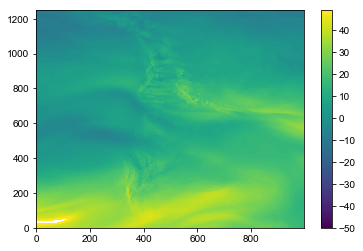

In [37]:
%pylab inline

plt.figure()
plt.contourf(outgrid[0,:,:],np.arange(-50,50))
plt.colorbar()
plt.show()

In [38]:
rcParams['font.family'] = 'Arial'
rcParams['font.style'] = 'normal'

def landmarks():
    landmark_dict = {'C':(-64.2123,-31.3154),
                    'M':(-68.7987,-32.8278),
                    '3':(-64.1131,-32.1767),
                    '4':(-64.34992,-33.13067), 
                    'Y':(-64.7545,-32.1062),
                    'S':(-63.978435,-31.715689)}
    return landmark_dict

landmark_dict=landmarks()

modname='UIUC_GFS'
run='2015110812'
tindex=0
outpath='/data/meso/a/snesbitt/wrf3911/fcsts/'+modname+'/'+run+'/images'

os.system('mkdir -p '+outpath)

basetime=pd.to_datetime(run, format='%Y%m%d%H')

files=[]
times=pd.date_range(start=basetime,periods=36,freq='H')

for time in times:
    files.append(Dataset('/data/meso/a/snesbitt/wrf3911/fcsts/'+run+'/wrfout_d01_'+time.strftime('%Y-%m-%d_%H:%M:%S')))

In [559]:
def make_plot(cffield,lfield,ufld,vfld,params):
# Get the latitude and longitude points
    lats, lons = latlon_coords(cffield)

    # Get the basemap object
    bm = Basemap(projection='lcc',width=3000*550,height=3000*375,
             resolution='i',lat_1=-32.8,lat_2=-32.8,lat_0=-32.8,lon_0=-67.0)

    # Create a figure
    fig = plt.figure(figsize=(12,9))

    # Add geographic outlines
    bm.drawcoastlines(linewidth=0.25)
    bm.drawstates(linewidth=0.5)
    bm.drawcountries(linewidth=0.5)

    # Convert the lats and lons to x and y.  Make sure you convert the lats and lons to
    # numpy arrays via to_np, or basemap crashes with an undefined RuntimeError.
    x, y = bm(to_np(lons), to_np(lats))


    if lfield is not None:
        CS=bm.contour(x, y, to_np(lfield), 10, colors="black", levels=params['llevels'],linewidths=1.0)
        plt.clabel(CS, inline=1, fontsize=12, fmt='%d')
    
    if ufld is not None:
        bm.barbs(x[::params['skip'],::params['skip']], 
                 y[::params['skip'],::params['skip']], 
                 to_np(ufld[::params['skip'],::params['skip']]),
                 to_np(vfld[::params['skip'],::params['skip']]), length=4, linewidth=0.75, zorder=10)

    if not('lalpha' in params):
        params['lalpha']=None
        
    # Draw the contours and filled contours
    bm.contourf(x, y, to_np(cffield), 10, cmap=get_cmap(params['ccmap']), levels=params['clevels'], extend='both',
               alpha=params['lalpha'])


    parallels = np.arange(-50.,-10.,2.)
    # labels = [left,right,top,bottom]
    bm.drawparallels(parallels,labels=[False,True,False,False],linewidth=0.5,dashes=[2,2])
    meridians = np.arange(-90.,-50.,2.)
    bm.drawmeridians(meridians,labels=[False,False,False,True],linewidth=0.5,dashes=[2,2])

    # Add a color bar
    plt.colorbar(shrink=.62, extend='both')

    timediff=params['times'][params['time_index']]-params['times'][0]
    timediff_secs=int(timediff.total_seconds()//3600)

    plt.title("University of Illinois 3-km GFS-WRF "+cffield.description+' ('+cffield.units+')\n'+
             "Initialized: "+params['times'][0].strftime('%Y-%m-%d %H:%M')+"Z Forecast hour: "+'{:03d}'.format(timediff_secs)+" Valid: "+params['times'][params['time_index']].strftime('%Y-%m-%d %H:%M')+'Z')

    for key in landmark_dict.keys():
        kx,ky=bm(landmark_dict[key][0],landmark_dict[key][1])
        plt.text(kx,ky,key,fontsize=10,
                        ha='center',va='center',color='b')
    #fig.figimage(im, fig.bbox.xmax-290, fig.bbox.ymin,zorder=10)

    plt.savefig(outpath+'/model.'+params['modname']+'.'+params['times'][0].strftime('%Y%m%d%H%M')+'.'+'{:03d}'.format(timediff_secs)+'_'+params['modfld']+'.png',dpi=225,bbox_inches='tight')


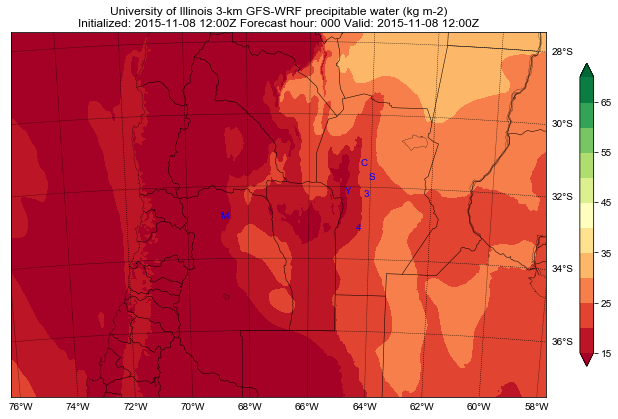

In [560]:
#=====================PRECIPITABLE WATER=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'pwat',
        'cfield':'pw',
        'clevels':np.arange(15,75,5),
        'ccmap':"RdYlGn",
        'llevels':None,
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
lfield = None
ufld = None
vfld = None

make_plot(cffield,lfield,ufld,vfld,params)

<bound method Timedelta.total_seconds of Timedelta('1 days 10:00:00')>


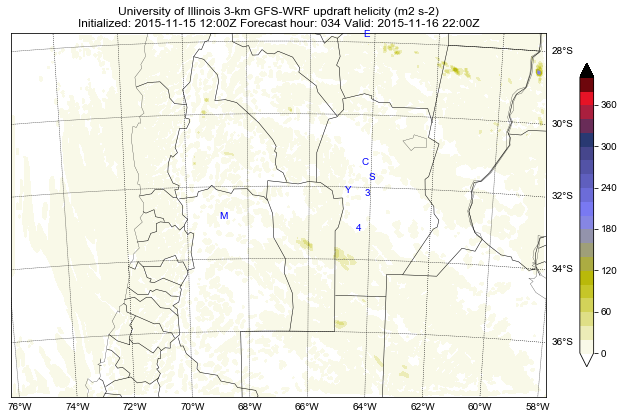

In [497]:
#=========================MIN UH=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'upheli',
        'cfield':'UP_HELI_MIN',
        'clevels':np.arange(0,420,20),
        'ccmap':"gist_stern_r",
        'llevels':None,
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
cffield.values=cffield.values*-1.
cffield.attrs['description']='updraft helicity'
cffield.attrs['units']='m2 s-2'
lfield = None
ufld = None
vfld = None

make_plot(cffield,lfield,ufld,vfld,params)

<bound method Timedelta.total_seconds of Timedelta('1 days 10:00:00')>


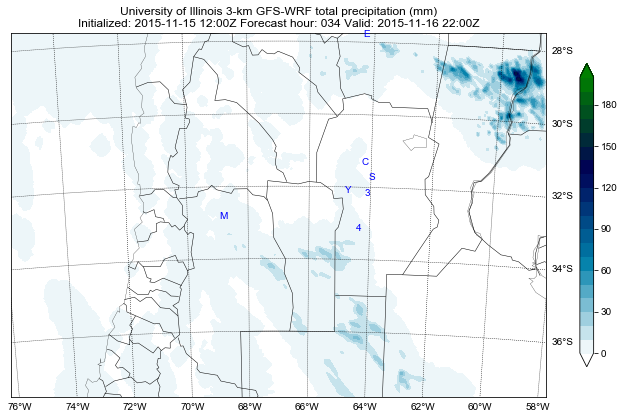

In [496]:
#====================TOTAL PRECIPITAITON=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'precip_acc',
        'cfield':'RAINNC',
        'clevels':np.arange(0,205,10),
        'ccmap':"ocean_r",
        'llevels':None,
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield=None
cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
cffield.attrs['description']='total precipitation'
cffield.attrs['units']='mm'
lfield = None
ufld = None
vfld = None

make_plot(cffield,lfield,ufld,vfld,params)

<bound method Timedelta.total_seconds of Timedelta('1 days 10:00:00')>


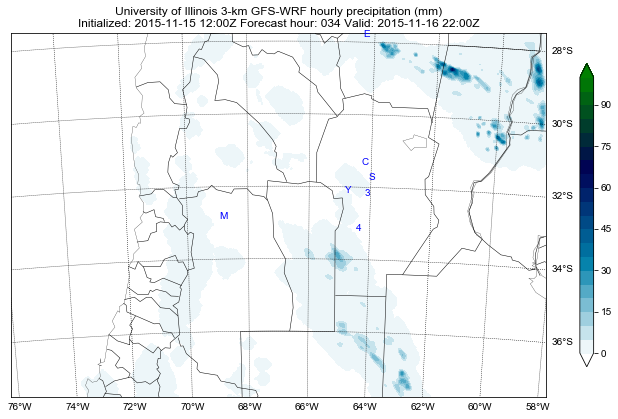

In [495]:
#====================1 HOUR PRECIPITAITON=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'precip_1hr',
        'cfield':'PREC_ACC_NC',
        'clevels':np.arange(0,105,5),
        'ccmap':"ocean_r",
        'llevels':None,
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield=None
cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
cffield.attrs['description']='hourly precipitation'
cffield.attrs['units']='mm'
lfield = None
ufld = None
vfld = None

make_plot(cffield,lfield,ufld,vfld,params)

<bound method Timedelta.total_seconds of Timedelta('1 days 10:00:00')>


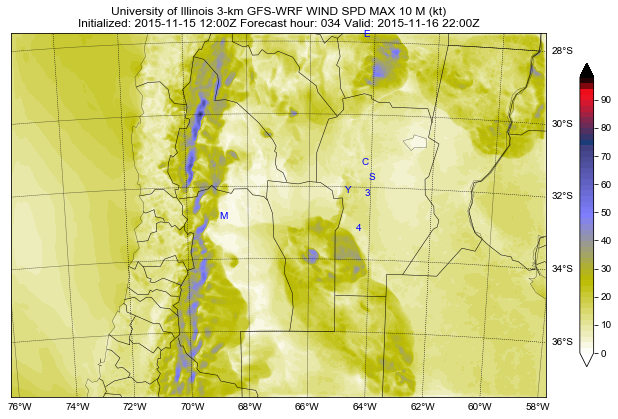

In [503]:
#====================MAX SFC WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'max_sfc_wind',
        'cfield':'WSPD10MAX',
        'clevels':np.arange(0,100,2),
        'ccmap':"gist_stern_r",
        'llevels':None,
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield = getvar(files, params['cfield'], timeidx=params['time_index'], units='kt')
cffield.values=cffield.values*1.94384
#cffield.attrs['description']='maximum surface wind'
cffield.attrs['units']='kt'
lfield = None
ufld = None
vfld = None

make_plot(cffield,lfield,ufld,vfld,params)

<bound method Timedelta.total_seconds of Timedelta('1 days 10:00:00')>


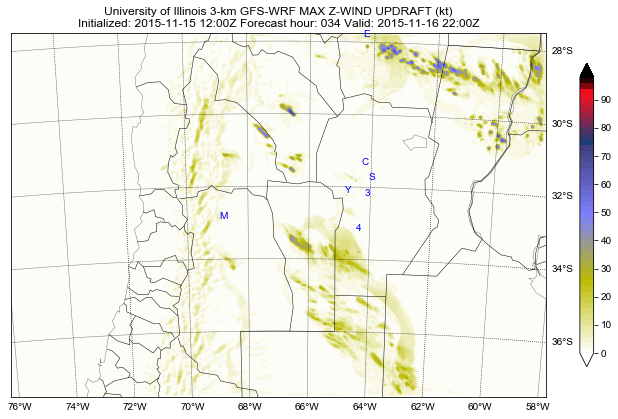

In [504]:
#====================MAX UPDRAFT=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'max_w',
        'cfield':'W_UP_MAX',
        'clevels':np.arange(0,100,2),
        'ccmap':"gist_stern_r",
        'llevels':None,
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield = getvar(files, params['cfield'], timeidx=params['time_index'], units='kt')
cffield.values=cffield.values*1.94384
cffield.attrs['description']='maximum updraft velocity'
cffield.attrs['units']='kt'
lfield = None
ufld = None
vfld = None

make_plot(cffield,lfield,ufld,vfld,params)

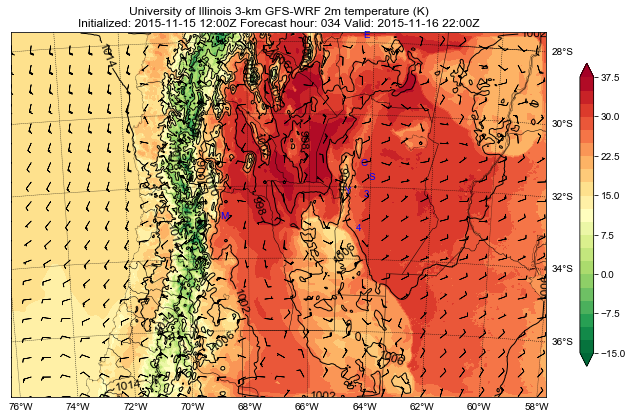

In [553]:
#=====================2 M TEMP=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'T2',
        'cfield':'T2',
        'clevels':np.arange(-15,40,2.5),
        'ccmap':"RdYlGn_r",
        'llevels':np.arange(970,1040,4),
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield = getvar(files, params['cfield'], timeidx=params['time_index'],units='degC')
cffield.attrs['description']='2m temperature'
cffield.attrs['temperature']='degC'
cffield.values=cffield.values-273.15
lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = uvmet.isel(u_v=0)
vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,ufld,vfld,params)

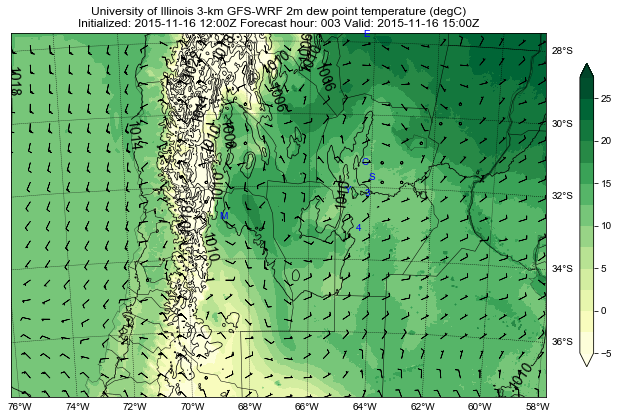

In [378]:
#=====================2 M DWPT=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'TD2',
        'cfield':'td2',
        'clevels':np.arange(-5,30,2.5),
        'ccmap':"YlGn",
        'llevels':np.arange(970,1040,4),
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield = getvar(files, params['cfield'], timeidx=params['time_index'])
cffield.values=cffield.values
lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = uvmet.isel(u_v=0)
vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,ufld,vfld,params)

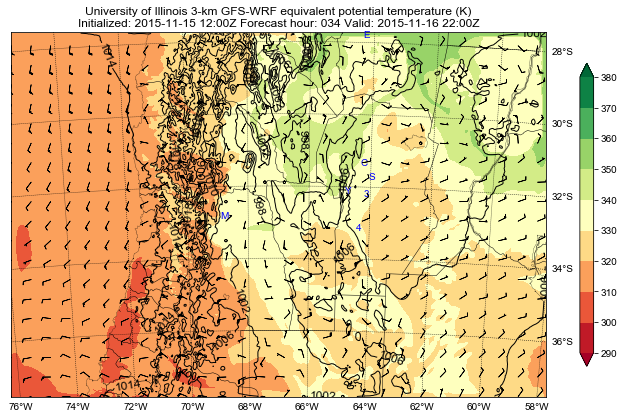

In [555]:
#=====================SFC THETAE=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'theta_e_sfc',
        'cfield':'eth',
        'clevels':np.arange(290,390,10),
        'ccmap':"RdYlGn",
        'llevels':np.arange(970,1040,4),
        'time_index':tindex,
        'times':times,
        'skip':20}

cffield = getvar(files, params['cfield'], timeidx=params['time_index'], units='K')
cffield=cffield.isel(bottom_top=0)
lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = uvmet.isel(u_v=0)
vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,ufld,vfld,params)

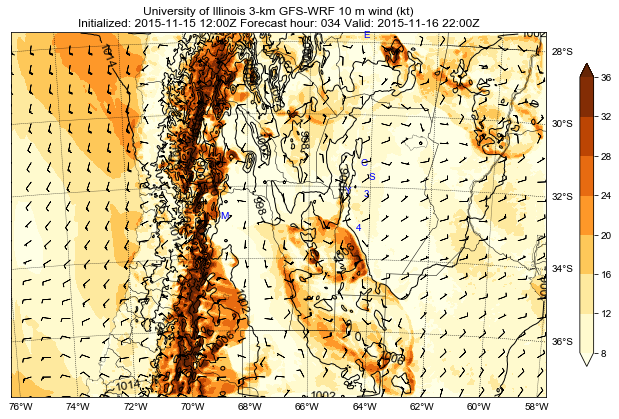

In [556]:
#=====================10 M WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'WSP',
        'cfield':'wsp',
        'clevels':np.arange(8,40,4),
        'ccmap':"YlOrBr",
        'llevels':np.arange(970,1040,4),
        'time_index':tindex,
        'times':times,
        'skip':20}


uvmet10 = getvar(files, 'wspd_wdir10', timeidx=params['time_index'], units="kt")

cffield = uvmet10.isel(wspd_wdir=0)
cffield.attrs['description']='10 m wind'
lfield = getvar(files, 'slp', timeidx=params['time_index'], units='hPa')
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = uvmet.isel(u_v=0)
vfld = uvmet.isel(u_v=1)

make_plot(cffield,lfield,ufld,vfld,params)

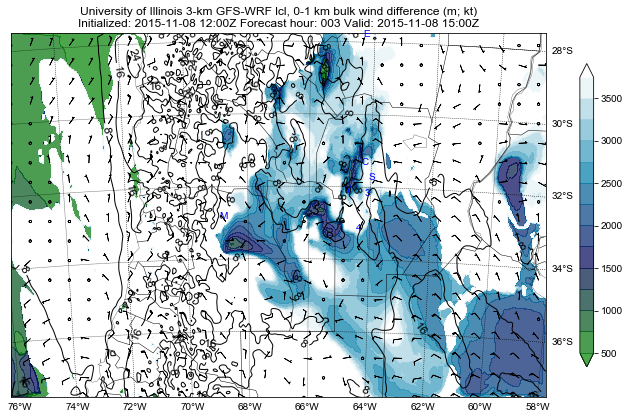

In [415]:
#=====================0-1 KM WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'lcl_0-1kmwind',
        'cfield':'lcl_0-1kmwind',
        'clevels':np.arange(500,4000,250),
        'ccmap':"ocean",
        'llevels':np.arange(8,72,8),
        'lalpha':0.7,
        'time_index':tindex,
        'times':times,
        'skip':20}


uvmet10 = getvar(files, 'wspd_wdir10', timeidx=params['time_index'], units="kt")

ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
z = getvar(files, 'z', timeidx=params['time_index'], units="m")
p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

ter_3d=np.tile(ter.values,[41,1,1])
z.values=z.values-ter.values
u2 = interplevel(u, z, 1000)
v2 = interplevel(v, z, 1000)
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = uvmet.isel(u_v=0)
vfld = uvmet.isel(u_v=1)

u2.values=u2.values-ufld.values
v2.values=v2.values-vfld.values

lfield = uvmet10.isel(wspd_wdir=0)
lfield.values=smooth2d(np.sqrt(u2.values**2.+v2.values**2.),3)

sounding_parameters=getvar(files, 'cape_2d', timeidx=params['time_index'])
cffield = sounding_parameters.isel(mcape_mcin_lcl_lfc=3)

cffield.attrs['description']='lcl, 0-1 km bulk wind difference'
cffield.attrs['units']='m; kt'
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = u2
vfld = v2

make_plot(cffield,lfield,ufld,vfld,params)

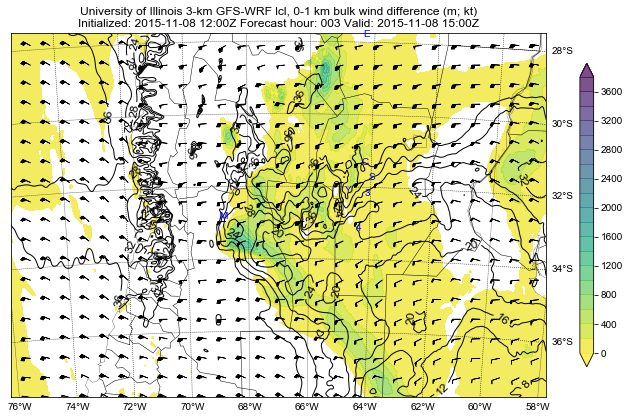

In [414]:
#=====================MLCAPE; 0-6 KM WIND=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'mlcape_0-6kmwind',
        'cfield':'mlcape_0-6kmwind',
        'clevels':np.arange(0,4000,200),
        'ccmap':"viridis_r",
        'llevels':np.arange(8,40,4),
        'lalpha':0.7,
        'time_index':tindex,
        'times':times,
        'skip':20}


uvmet10 = getvar(files, 'wspd_wdir10', timeidx=params['time_index'], units="kt")

ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
z = getvar(files, 'z', timeidx=params['time_index'], units="m")
p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

ter_3d=np.tile(ter.values,[41,1,1])
z.values=z.values-ter.values
u2 = interplevel(u, z, 6000)
v2 = interplevel(v, z, 6000)
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = uvmet.isel(u_v=0)
vfld = uvmet.isel(u_v=1)

u2.values=u2.values-ufld.values
v2.values=v2.values-vfld.values

lfield = uvmet10.isel(wspd_wdir=0)
lfield.values=smooth2d(np.sqrt(u2.values**2.+v2.values**2.),3)

sounding_parameters=getvar(files, 'cape_2d', timeidx=params['time_index'])
cffield = sounding_parameters.isel(mcape_mcin_lcl_lfc=0)

cffield.attrs['description']='lcl, 0-6 km bulk wind difference'
cffield.attrs['units']='m; kt'
uvmet = getvar(files, 'uvmet10', timeidx=params['time_index'], units='kt')
ufld = u2
vfld = v2

make_plot(cffield,lfield,ufld,vfld,params)

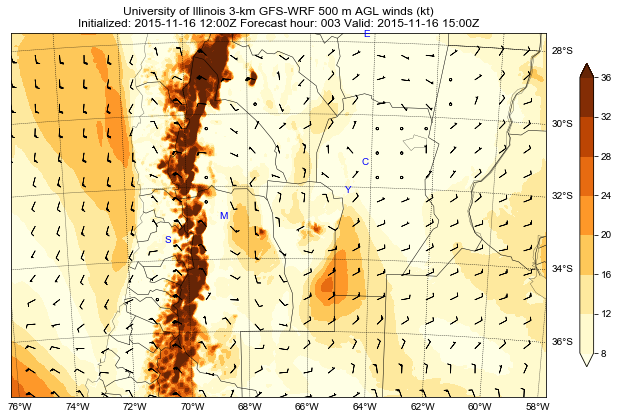

In [338]:
#=========================500 M=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'wsp_500m',
        'cfield':'wsp_500m',
        'clevels':np.arange(8,40,4),
        'ccmap':"YlOrBr",
        'llevels':np.arange(510,606,6),
        'time_index':tindex,
        'times':times,
        'skip':25}

uvmet = getvar(files, 'wspd_wdir', timeidx=params['time_index'], units="kt")
wspd = uvmet.isel(wspd_wdir=0)
ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
z = getvar(files, 'z', timeidx=params['time_index'], units="m")
p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

ter_3d=np.tile(ter.values,[41,1,1])
z.values=z.values-ter.values
cffield = interplevel(wspd, z, 500)
cffield.attrs['description']='500 m AGL winds'
lfield = None
ufld = interplevel(u, z, 500)
vfld = interplevel(v, z, 500)

make_plot(cffield,lfield,ufld,vfld,params)

<bound method Timedelta.total_seconds of Timedelta('1 days 10:00:00')>


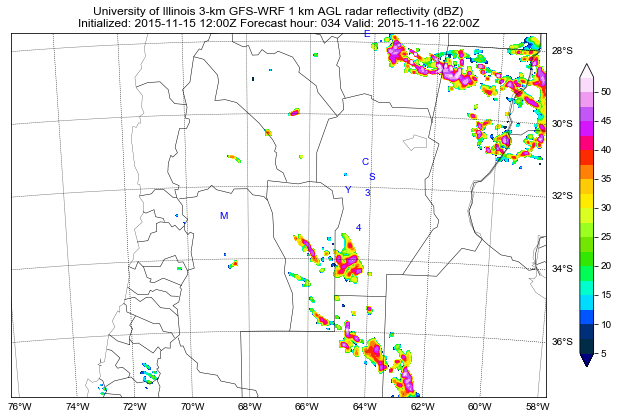

In [481]:
#=========================1 km DBZ=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'radar_1km',
        'cfield':'radar_1km',
        'clevels':np.arange(5,55,2.5),
        'ccmap':"gist_ncar",
        'llevels':np.arange(510,606,6),
        'time_index':tindex,
        'times':times,
        'skip':25}

dbz = getvar(files, 'dbz', timeidx=params['time_index'])
ter = getvar(files, 'ter', timeidx=params['time_index'], units="m")
z = getvar(files, 'z', timeidx=params['time_index'], units="m")

ter_3d=np.tile(ter.values,[41,1,1])
z.values=z.values-ter.values
cffield = interplevel(dbz, z, 1000)
cffield.values=np.ma.masked_less(cffield.values,5.)
cffield.attrs['description']='1 km AGL radar reflectivity'
lfield = None
ufld=None
vfld=None

make_plot(cffield,lfield,ufld,vfld,params)

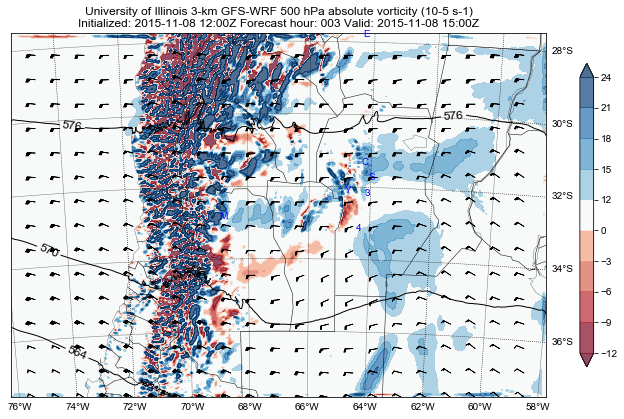

In [418]:
#=========================500 HPA=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'500avo',
        'cfield':'avo',
        'clevels':[-12,-9,-6,-3,0,12,15,18,21,24],
        'ccmap':"RdBu",
        'lalpha':0.7,
        'llevels':np.arange(510,606,6),
        'time_index':tindex,
        'times':times,
        'skip':25}

avo = getvar(files, 'avo', timeidx=params['time_index'])
z = getvar(files, 'z', timeidx=params['time_index'], units="dm")
p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

cffield = interplevel(avo, p, 500)
cffield.values=cffield.values*-1
cffield.attrs['description']='500 hPa absolute vorticity'
lfield = interplevel(z, p, 500)
ufld = interplevel(u, p, 500)
vfld = interplevel(v, p, 500)

make_plot(cffield,lfield,ufld,vfld,params)

<bound method Timedelta.total_seconds of Timedelta('1 days 10:00:00')>


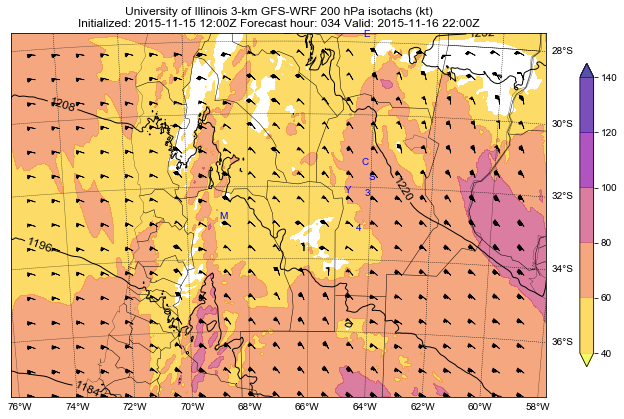

In [510]:
#=========================200 HPA=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'200_V',
        'cfield':'200_V',
        'clevels':np.arange(40,160,20),
        'ccmap':"plasma_r",
        'lalpha':0.7,
        'llevels':np.arange(1100,1300,12),
        'time_index':tindex,
        'times':times,
        'skip':25}

uvmet = getvar(files, 'wspd_wdir', timeidx=params['time_index'], units="kt")
wspd = uvmet.isel(wspd_wdir=0)
z = getvar(files, 'z', timeidx=params['time_index'], units="dm")
p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
u = getvar(files, 'ua', timeidx=params['time_index'], units="kt")
v = getvar(files, 'va', timeidx=params['time_index'], units="kt")

cffield = interplevel(wspd, p, 200)
cffield.values=cffield.values
cffield.attrs['description']='200 hPa isotachs'
cffield.values=np.ma.masked_less(cffield.values,40.)
lfield = interplevel(z, p, 200)
ufld = interplevel(u, p, 200)
vfld = interplevel(v, p, 200)

make_plot(cffield,lfield,ufld,vfld,params)

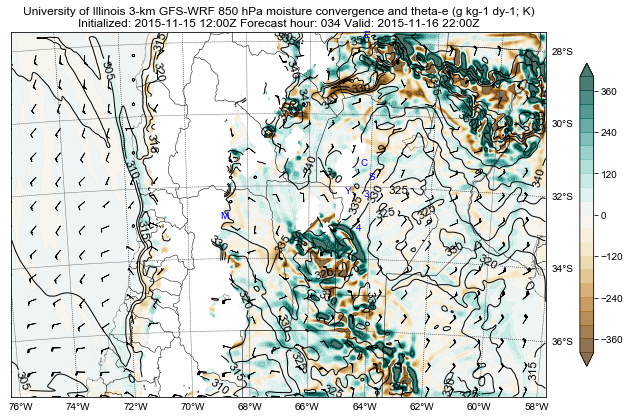

In [546]:
#=========================850 HPA=========================
params={'outpath':outpath,
        'modname':modname,
        'modfld':'850_theta',
        'cfield':'850_theta',
        'clevels':np.arange(-400,440,40),
        'ccmap':"BrBG",
        'lalpha':0.7,
        'llevels':np.arange(250,400,5),
        'time_index':tindex,
        'times':times,
        'skip':25}

uvmet = getvar(files, 'wspd_wdir', timeidx=params['time_index'], units="kt")
wspd = uvmet.isel(wspd_wdir=0)
eth = getvar(files, 'eth', timeidx=params['time_index'])
q = getvar(files, 'QVAPOR', timeidx=params['time_index'])

dx=uvmet.XLAT[1,0]-uvmet.XLAT[0,0]
dx=dx.values*111100
#MFC_advect = -( u*(dq/dx)+v*(dq/dy) )    ; advection term
#    MFC_conv    = -q*( (du/dx)+  (dv/dy) )      ; con(div)-vergence
#    MFC = MFC_advect + MFC_conv

p = getvar(files, 'p', timeidx=params['time_index'], units="hPa")
u = getvar(files, 'ua', timeidx=params['time_index'])
v = getvar(files, 'va', timeidx=params['time_index'])
ufld = interplevel(u, p, 850)
vfld = interplevel(v, p, 850)
qfld = interplevel(q, p, 850)

grad_q_x,grad_q_y = np.gradient(qfld.values)
grad_u_x,grad_u_y = np.gradient(ufld.values)
grad_v_x,grad_v_y = np.gradient(vfld.values)

MFC_advect=-1.*(ufld.values*grad_q_x/dx)+(vfld.values*grad_q_y/dx)
MFC_conv=-1.*qfld.values*((grad_u_x/dx)+(grad_v_y/dx))

cffield = qfld
cffield.values=smooth2d(86400.*1000.*(MFC_advect + MFC_conv),5)
cffield.attrs['description']='850 hPa moisture convergence and theta-e'
cffield.attrs['units']='g kg-1 dy-1; K'
lfield = smooth2d(interplevel(eth, p, 850),3)
ufld = ufld*1.94
vfld = vfld*1.94

make_plot(cffield,lfield,ufld,vfld,params)

In [547]:
cffield

<xarray.DataArray 'QVAPOR_850_hPa' (south_north: 374, west_east: 549)>
array([[ -15.647438,  -16.30419 ,  -16.119722, ...,   34.802864,   31.677221,
          27.174217],
       [ -14.053511,  -14.412605,  -14.387982, ...,   38.585526,   33.704842,
          28.22636 ],
       [ -12.213449,  -12.222062,  -12.164052, ...,   39.136299,   33.076023,
          27.082352],
       ..., 
       [   9.629951,   11.019691,   11.21053 , ...,  162.339401,  114.667587,
          59.811985],
       [  11.277982,   12.66433 ,   12.765948, ...,   75.486267,   51.766445,
          23.338781],
       [  12.101727,   13.541217,   13.522436, ...,   -8.722214,  -12.074688,
         -16.811714]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -76.2997 -76.2659 -76.2321 ...
    XLAT     (south_north, west_east) float32 -37.5019 -37.5042 -37.5066 ...
    XTIME    float32 2040.0
    Time     datetime64[ns] 2015-11-16T22:00:00
Dimensions without coordinates: south_north, west_east
At